## Trabalho CPE722 - Método Nãp-Supervisionado 

Autor: Micael Veríssimo de Araújo

e-mail: micaelvero@hotmail.com

Utilizar um método não-supervisionado exposto em sala na tentativa de obter uma classificação sinal (Higgs) e background ($t\overline{t}$) no canal $WH \to l \nu b \overline{b}$

In [1]:
# import all necessay library
%time
import numpy as np
from numpy import linalg as LA
from functions import ClusterMerits, AuxiliarFunctions
from sklearn import preprocessing
from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import norm
import matplotlib.mlab as mlab
from sklearn import preprocessing
from sklearn import metrics
import joblib

from sklearn import cross_validation
from sklearn.cluster import KMeans

#from pandas_ml import ConfusionMatrix

import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


/home/micael/.virtualenvs/MyAnalysis/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load the data and little data
%time
data_path = '/home/micael/MyWorkspace/DATA'
path_tosave = data_path+'/'+'Plots'
signal = np.load(data_path+'/'+'lvbb125Matrix.npy')[0:5000,:]
signal_scd = preprocessing.scale(signal)
signal_part = np.load(data_path+'/'+'lvbb125Matrix.npy')[0:250,:]
signal_trgt = np.ones(signal.shape[0])


ttbar = np.load(data_path+'/'+'TTbarMatrix.npy')
ttbar_scd = preprocessing.scale(ttbar)
ttbar_part = np.load(data_path+'/'+'TTbarMatrix.npy')[0:250,:]
bkg = ttbar
bkg_trgt = np.zeros(bkg.shape[0])

data = np.append(signal,bkg,axis=0)
data_scd = np.append(signal_scd,ttbar_scd,axis=0)

little_data = np.append(signal_part,ttbar_part,axis=0)

norm_factor = np.load(data_path+'/'+'desvio_variaveis.npy')

trgt = np.append(signal_trgt,bkg_trgt,axis=0)#signal_scd
trgt2 = trgt[:,np.newaxis] 
trgt2.shape
#sinal_e_trgt.shape
#signal.shape
#sinal_e_trgt[:,24]
data_trgt = np.append(data,trgt2,axis=1)
data_trgt[:,24]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

In [3]:
#normalize dataSet
norm_data = preprocessing.scale(data,with_std=False)

for i in range(norm_data.shape[1]):
    norm_data[:,i] = (1/norm_factor[i])*norm_data[:,i]
print np.mean(norm_data),np.std(norm_data)

1.12431545555e-15 1.0607191258


-0.000581016014231


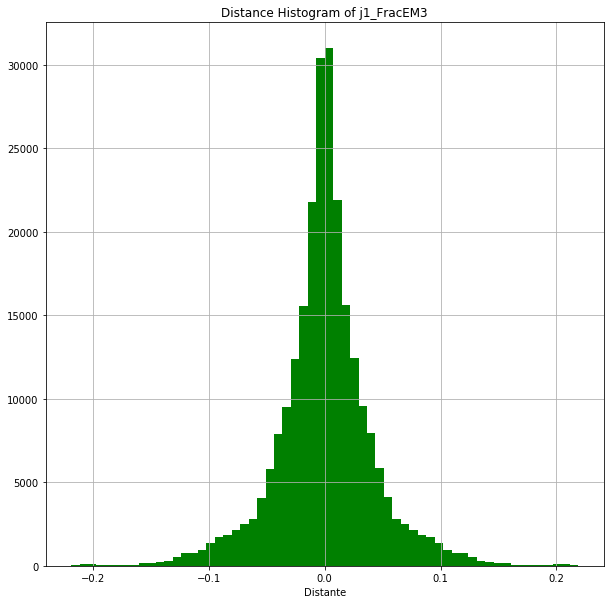

0.00289182694075


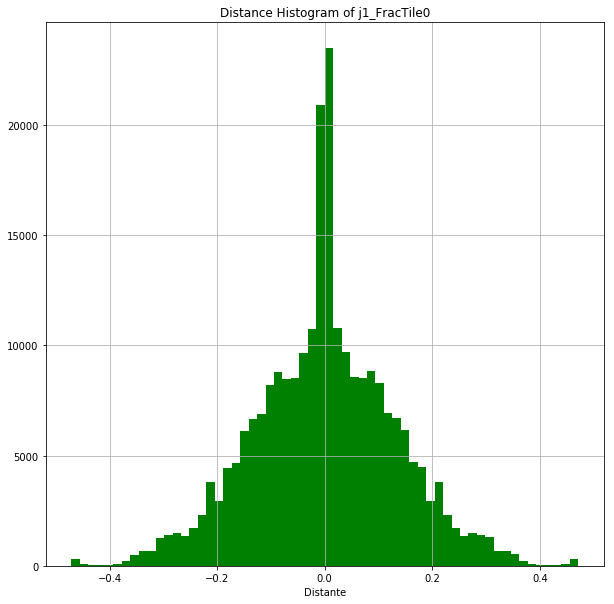

-0.00240969412538


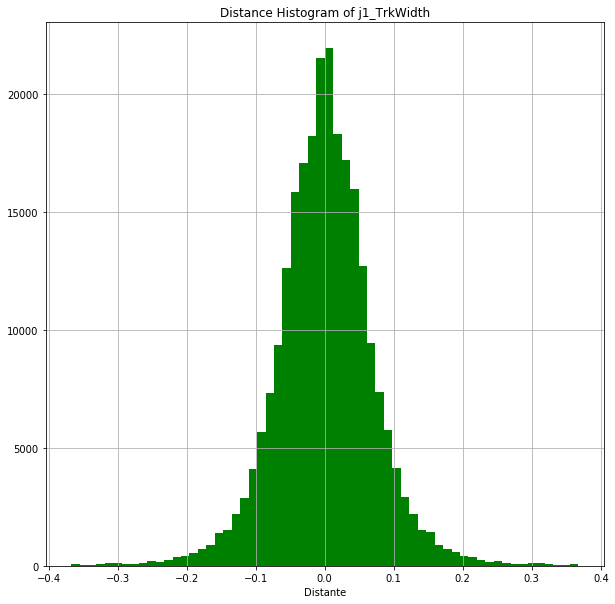

0.00312248689221


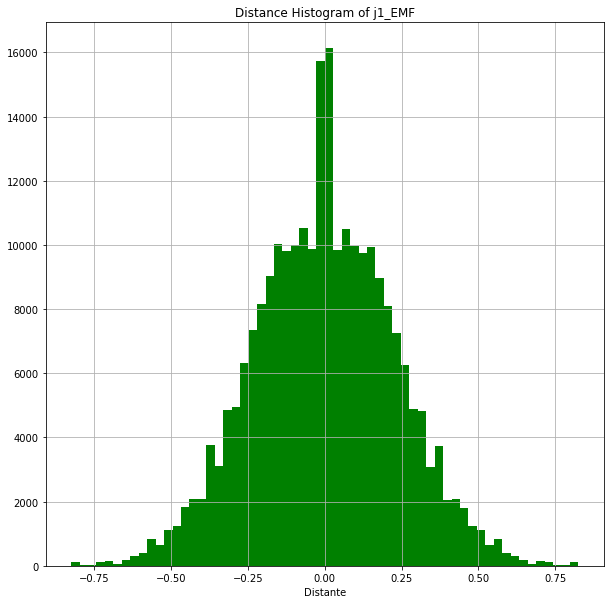

-0.00226972043701


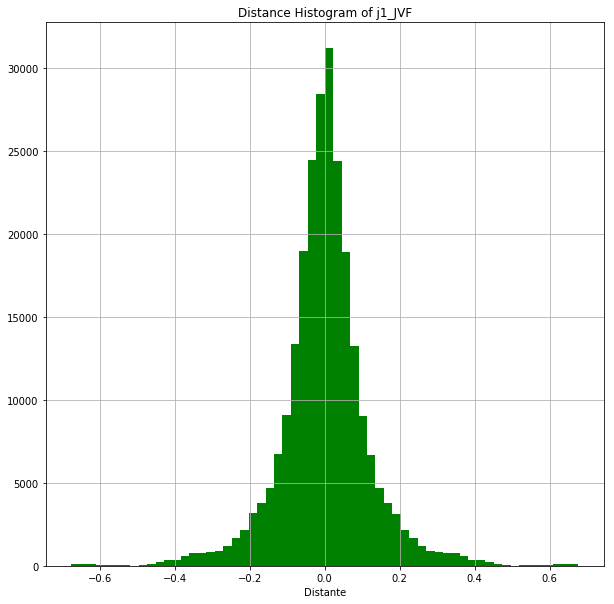

-0.0435757982117


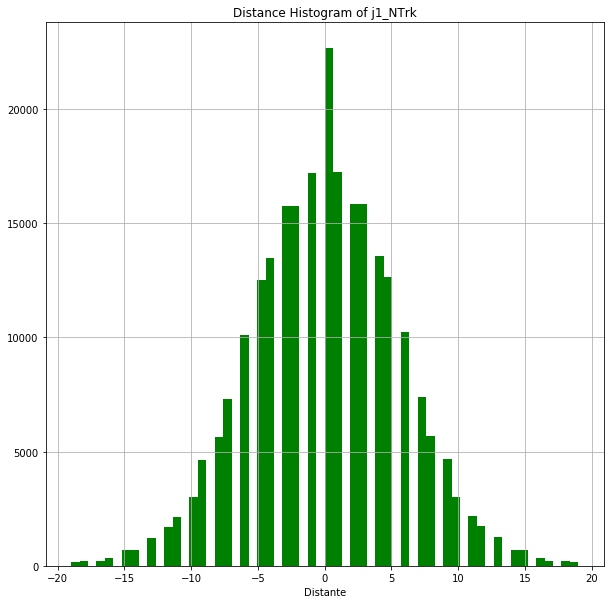

2.115519621


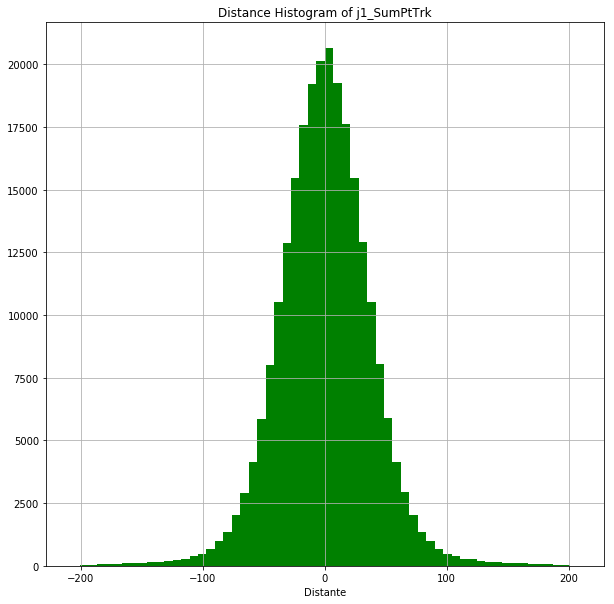

0.80503771918


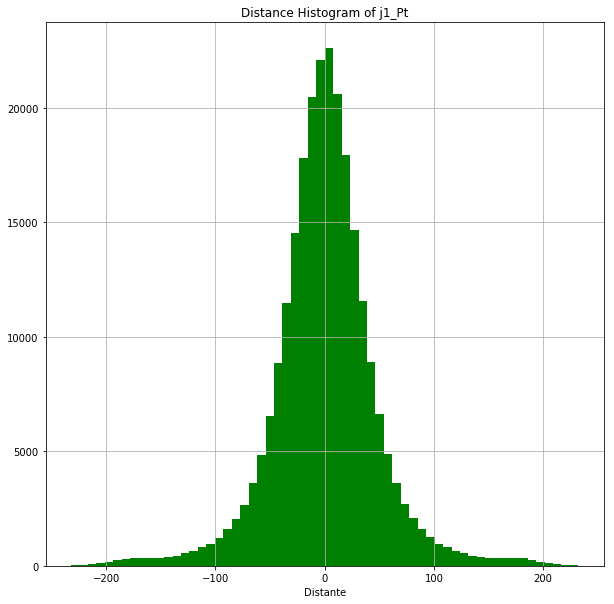

0.0479769381176


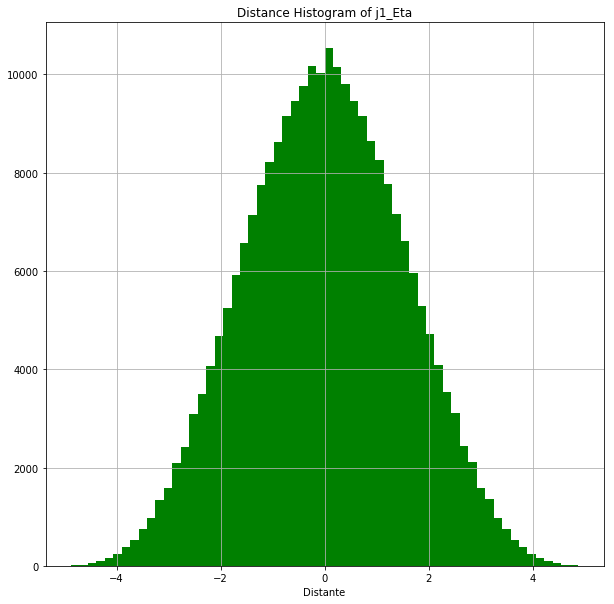

-0.0158218530711


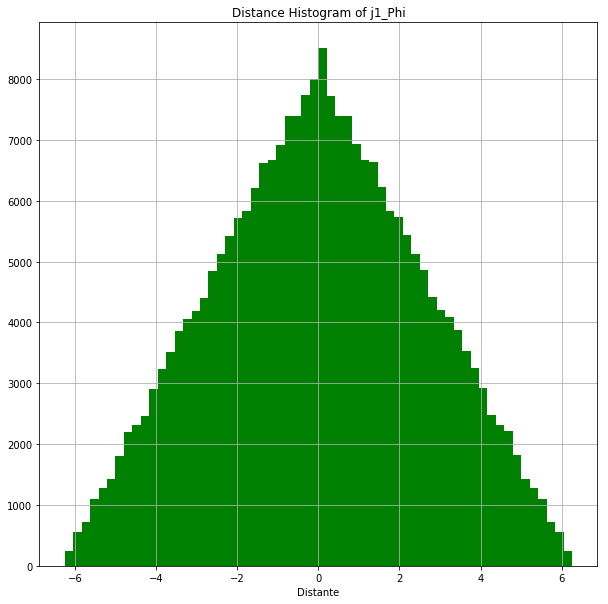

12.3564890778


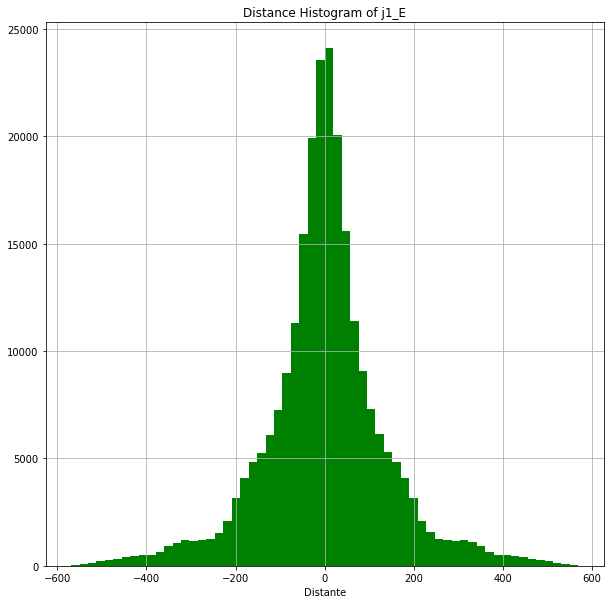

4.11809512971


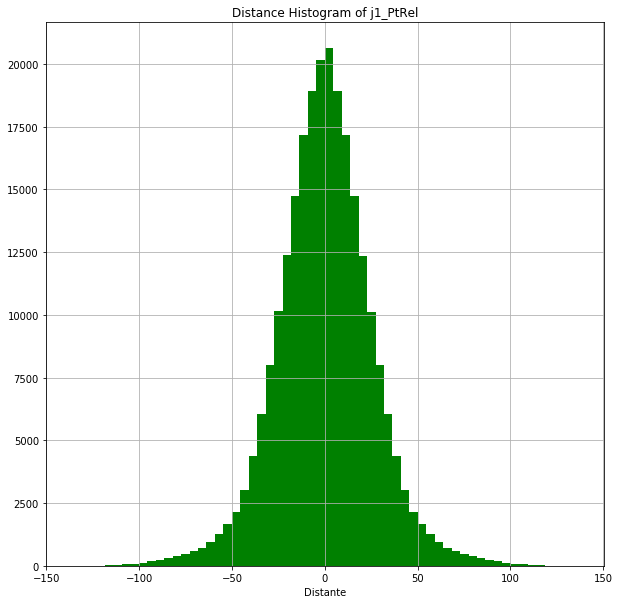

0.000961007303751


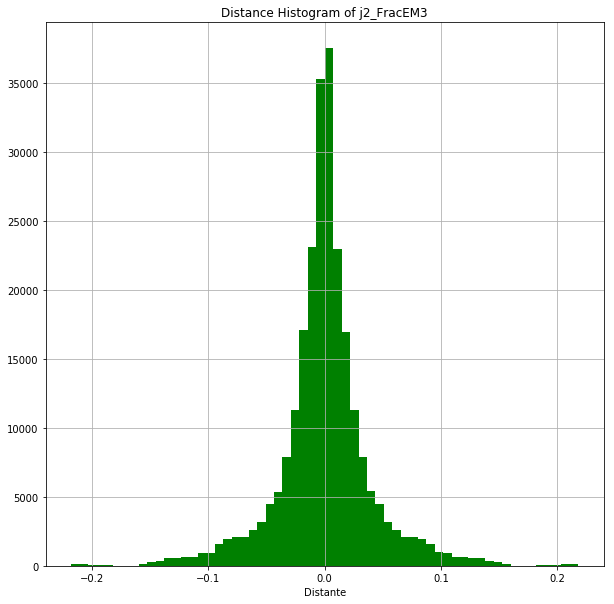

0.00349944525265


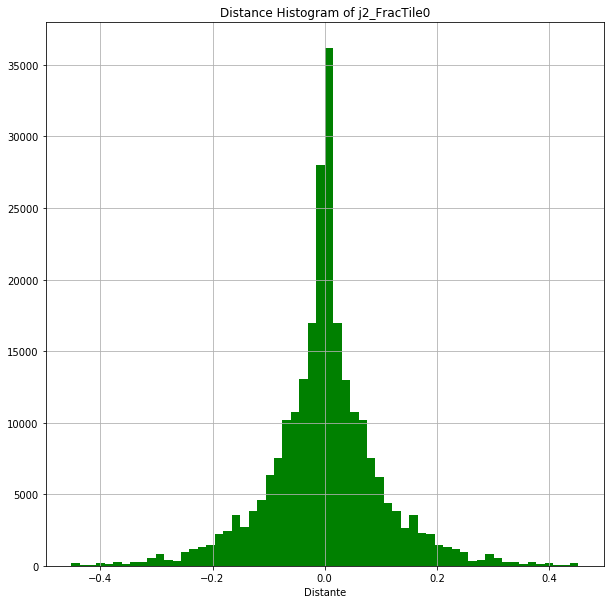

0.00203450919002


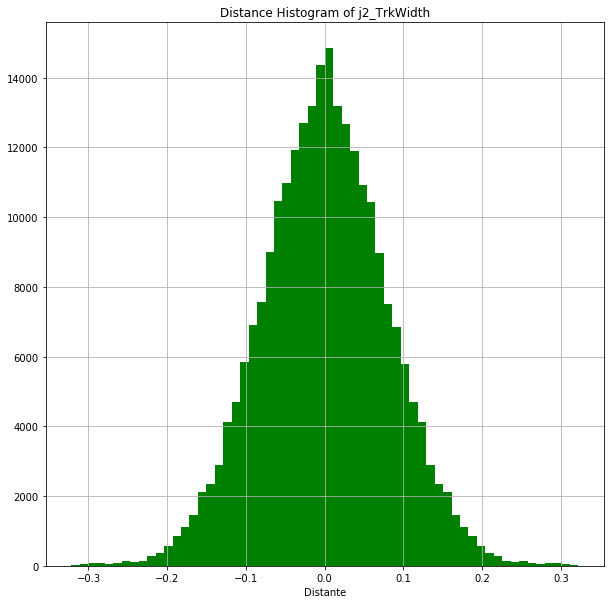

0.0110910346647


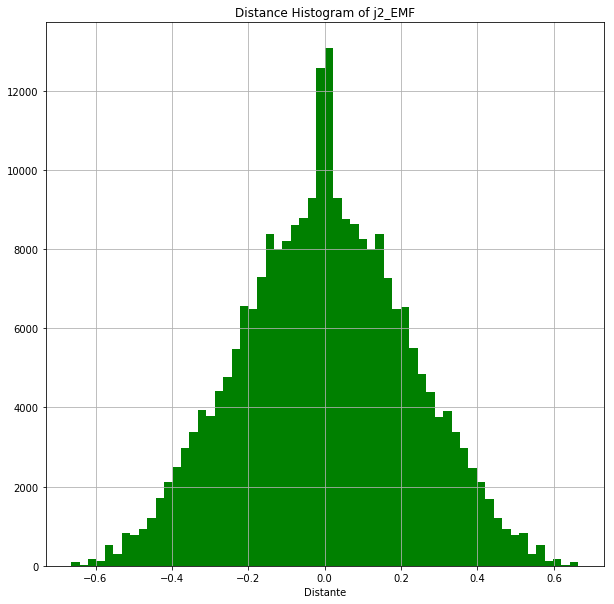

-0.000948708279003


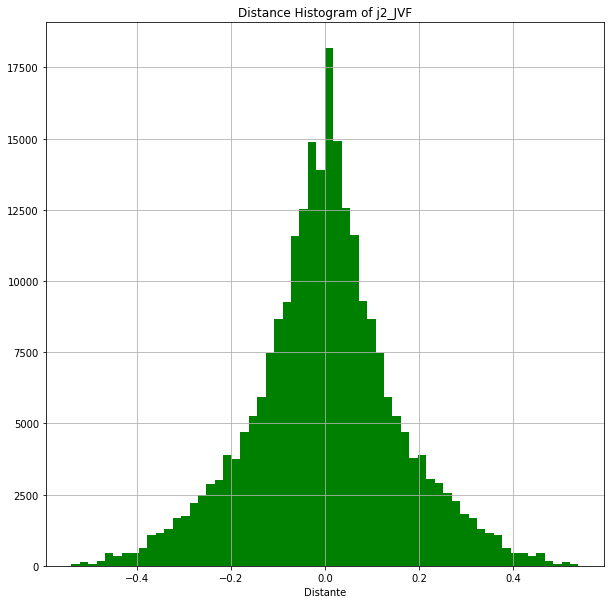

0.201909907847


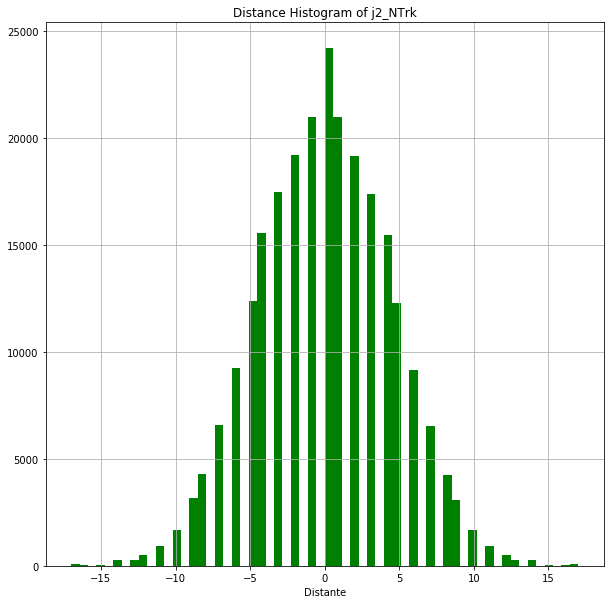

1.46169878547


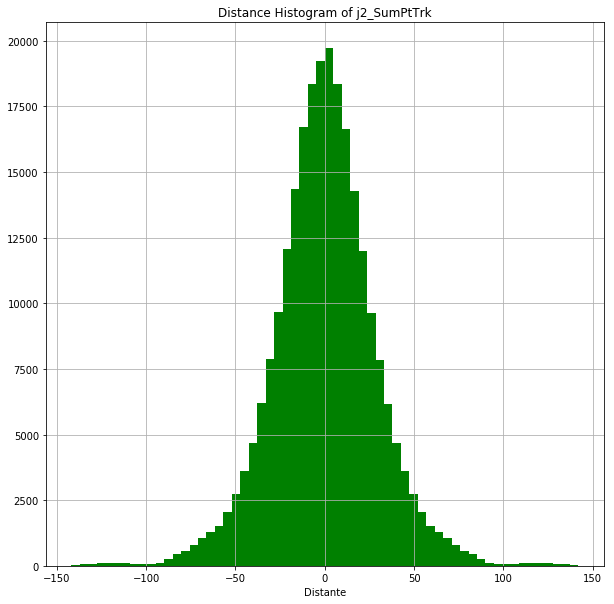

3.80805495296


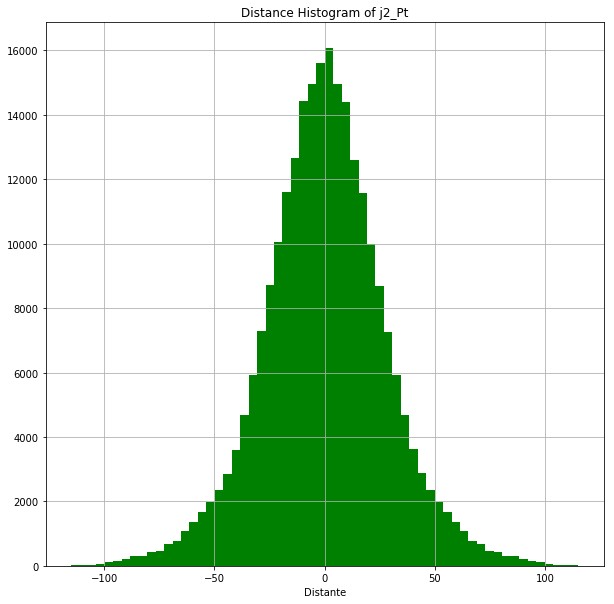

-0.00947132501295


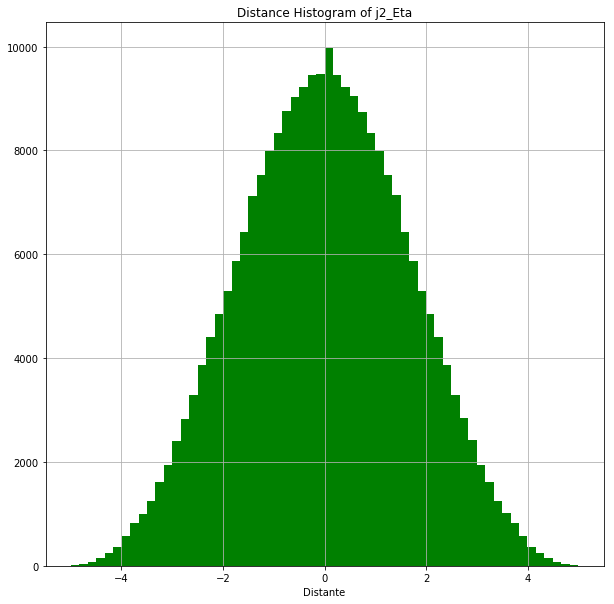

0.0242545045883


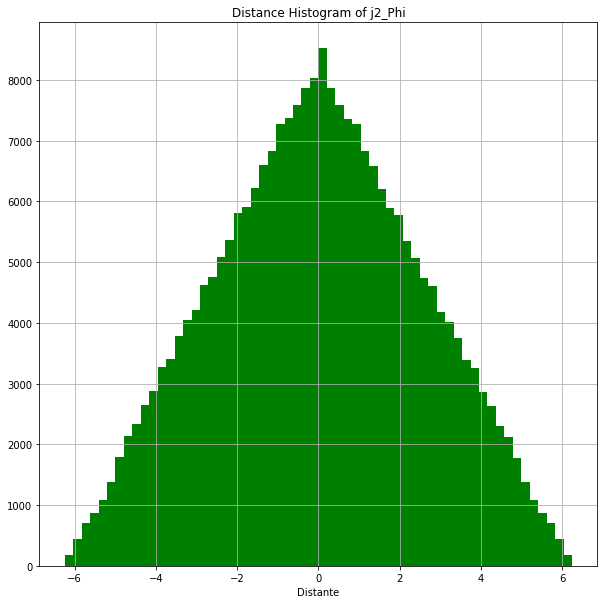

11.3478712671


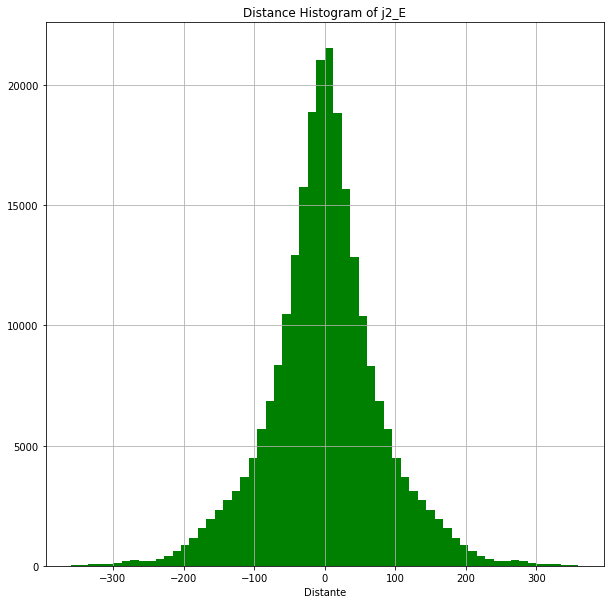

4.11809512971


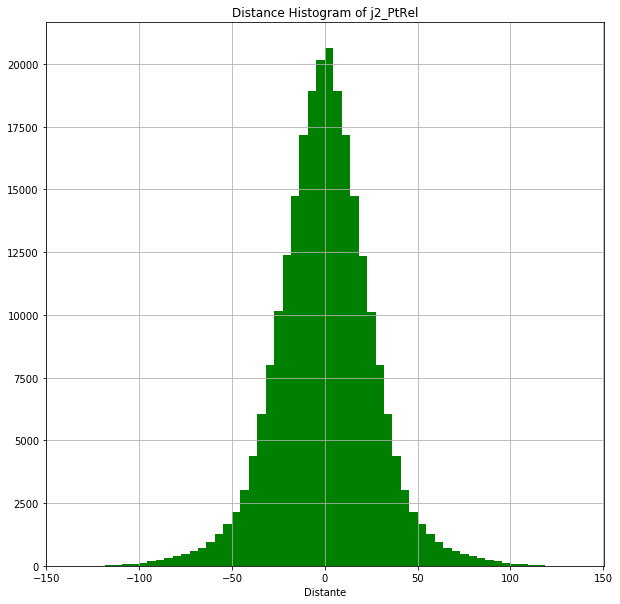

In [23]:
# distance histograms - use to estimate the sigma | better way?
var_std = np.zeros(len(range(little_data.shape[1])))
variables = "j1_FracEM3,j1_FracTile0,j1_TrkWidth,j1_EMF,j1_JVF,j1_NTrk,j1_SumPtTrk,j1_Pt,j1_Eta,j1_Phi,j1_E,j1_PtRel,j2_FracEM3,j2_FracTile0,j2_TrkWidth,j2_EMF,j2_JVF,j2_NTrk,j2_SumPtTrk,j2_Pt,j2_Eta,j2_Phi,j2_E,j2_PtRel"
for variable,k in zip(variables.split(','),range(little_data.shape[1])):
    for i in range(little_data.shape[0]-1):
        for j in range(little_data.shape[0]):
            dist0 = little_data[i,k]-little_data[j,k]
            #dist1 = abs(little_data[i,k]-little_data[j,k])
            dataBuffer0 = np.array([dist0])
            #dataBuffer1 = np.array([dist1])
            if i==0:
                data0 = dataBuffer0
                #data1 = dataBuffer1
            else:
                data0 = np.append(data0,dataBuffer0, axis=0)
                #data1 = np.append(data1,dataBuffer1, axis=0)
    print (np.std(data[:,k])-(np.std(data0)/np.sqrt(2)))
    var_std[k] = (np.std(data0)/np.sqrt(2))
           
    plt.figure(figsize=(10,10))
    plt.hist(data0,60,color='g')
    plt.xlabel('Distante')
    plt.title('Distance Histogram of '+variable)
    plt.grid()
    plt.savefig(path_tosave+'/'+'Histogram_'+variable+'_distances.pdf')
    plt.show()

In [29]:
# save the normalize factors
var_std.shape
np.save(data_path+'/'+'desvio_variaveis',var_std)

In [5]:
kmeans = KMeans(n_clusters=5,random_state=0).fit(norm_data)
output = kmeans.predict(norm_data)
cluster_list = []
cluster_list = [norm_data[output==i] for i in range(len(np.unique(output)))]
print len(cluster_list)


5


## Inicio K-Means

In [4]:
n_folds = 10
max_clusters = 13
n_inits = 1

Acc_par = np.zeros([n_folds,len(range(2,max_clusters))])
SP_par = np.zeros([n_folds,len(range(2,max_clusters))])
Sil_par = np.zeros([n_folds,len(range(2,max_clusters))])

F_in = np.zeros([n_folds,len(range(2,max_clusters))])
F_out = np.zeros([n_folds,len(range(2,max_clusters))])

Acc_final = np.zeros([n_folds,len(range(2,max_clusters))])
SP_final = np.zeros([n_folds,len(range(2,max_clusters))])
Sil_final = np.zeros([n_folds,len(range(2,max_clusters))])
Acc_score_final = np.zeros([n_folds,len(range(2,max_clusters))])

print range(2,max_clusters)
Acc_final.shape,SP_final.shape,Sil_final.shape,F_in.shape,F_out.shape


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


((10, 11), (10, 11), (10, 11), (10, 11), (10, 11))

In [5]:
for icluster in range(2,max_clusters):
    print '=================================',icluster,'==========================================='
    if icluster == 2:
        CVO = cross_validation.StratifiedKFold(trgt,n_folds)
        CVO = list(CVO)
        
        classifiers = {}
        for ifold in range(n_folds):
            train_id, test_id = CVO[ifold]
            for i_init in range(n_inits):
                print ('Processing: Fold %i of %i Init %i of %i'%(
                    ifold+1, n_folds, 
                    i_init+1, n_inits)) 

                km = KMeans(n_clusters=icluster,random_state=0).fit(norm_data[train_id])
                classifiers[ifold]=km
                
                km_output = classifiers[ifold].predict(norm_data)
                
                cluster_list = []
                cluster_list = [norm_data[km_output==0],norm_data[km_output==1]]
                
                Acc_final[ifold,icluster-2] = round(np.mean(ClusterMerits.Acc(km_output[test_id],trgt[test_id])),3)
                Acc_score_final[ifold,icluster-2] = round(metrics.accuracy_score(trgt[test_id],km_output[test_id]),3)
                SP_final[ifold,icluster-2] = round(ClusterMerits.SP(km_output[test_id],trgt[test_id]),3)
                Sil_final[ifold,icluster-2] = round(metrics.silhouette_score(norm_data[test_id],km_output[test_id]),3)
                
                F_in[ifold,icluster-2] = round(ClusterMerits.DispIntraClass(cluster_list),3)
                F_out[ifold,icluster-2] = round(abs(F_in[ifold,icluster-2]-ClusterMerits.DispTotal(norm_data)))
    else:
        
        CVO = cross_validation.StratifiedKFold(trgt,n_folds)
        CVO = list(CVO)
        
        classifiers = {}
        for ifold in range(n_folds):
            train_id, test_id = CVO[ifold]
            for i_init in range(n_inits):
                print ('Processing: Fold %i of %i Init %i of %i'%(
                    ifold+1, n_folds, 
                    i_init+1, n_inits)) 

                km = KMeans(n_clusters=icluster,random_state=0).fit(norm_data[train_id])
                classifiers[ifold]=km
                km_output = classifiers[ifold].predict(norm_data)
                
                cluster_list = []
                cluster_list = [norm_data[km_output==i] for i in range(len(np.unique(km_output)))]
                
                F_in[ifold,int(icluster-2)] = round(ClusterMerits.DispIntraClass(cluster_list),3)
                F_out[ifold,int(icluster-2)] = round(abs(F_in[ifold,int(icluster-2)]-ClusterMerits.DispTotal(norm_data)),3)
            
                #Acc_par[ifold,int(icluster/2)] = round(np.mean(ClusterMerits.Acc(knn_output[test_id],new_trgt[test_id])),3)
                #SP_par[ifold,int(icluster/2)] = round(ClusterMerits.SP(knn_output[test_id],new_trgt[test_id]),3)
                #Sil_par[ifold,int(icluster/2)] = round(metrics.silhouette_score(norm_data[test_id],knn_output[test_id]),3)
                
                class_final = np.zeros(trgt.shape)
                for i in range(trgt.shape[0]):
                    if sum(trgt[km_output==km_output[i]]==1)/float(sum(km_output==km_output[i])) >= 0.5:
                        class_final[i]=1
                    else:
                        class_final[i]=0
                
                Acc_final[ifold,int(icluster-2)] = round(np.mean(ClusterMerits.Acc(class_final[test_id],trgt[test_id])),3)
                Acc_score_final[ifold,int(icluster-2)] = round(metrics.accuracy_score(trgt[test_id],km_output[test_id]),3)
                SP_final[ifold,int(icluster-2)] = round(ClusterMerits.SP(class_final[test_id],trgt[test_id]),3)
                Sil_final[ifold,int(icluster-2)] = round(metrics.silhouette_score(norm_data[test_id],class_final[test_id]),3)
                
        

================================= 2 ===========================================
Processing: Fold 1 of 10 Init 1 of 1


functions/ClusterMerits.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (media == 'm'):


Processing: Fold 2 of 10 Init 1 of 1
Processing: Fold 3 of 10 Init 1 of 1
Processing: Fold 4 of 10 Init 1 of 1
Processing: Fold 5 of 10 Init 1 of 1
Processing: Fold 6 of 10 Init 1 of 1
Processing: Fold 7 of 10 Init 1 of 1
Processing: Fold 8 of 10 Init 1 of 1
Processing: Fold 9 of 10 Init 1 of 1
Processing: Fold 10 of 10 Init 1 of 1
================================= 3 ===========================================
Processing: Fold 1 of 10 Init 1 of 1
Processing: Fold 2 of 10 Init 1 of 1
Processing: Fold 3 of 10 Init 1 of 1
Processing: Fold 4 of 10 Init 1 of 1
Processing: Fold 5 of 10 Init 1 of 1
Processing: Fold 6 of 10 Init 1 of 1
Processing: Fold 7 of 10 Init 1 of 1
Processing: Fold 8 of 10 Init 1 of 1
Processing: Fold 9 of 10 Init 1 of 1
Processing: Fold 10 of 10 Init 1 of 1
================================= 4 ===========================================
Processing: Fold 1 of 10 Init 1 of 1
Processing: Fold 2 of 10 Init 1 of 1
Processing: Fold 3 of 10 Init 1 of 1
Processing: Fold 4 of 10

In [18]:
F_in.shape

(10, 11)

In [6]:
# accuracia media
acc_mean = np.zeros([Acc_final.shape[1],])
sigma_acc = np.zeros([Acc_final.shape[1],])

for i in range(acc_mean.shape[0]):
    acc_mean[i] = np.mean(Acc_final[:,i])
    sigma_acc[i] = np.std(Acc_final[:,i])

acc_score_mean = np.zeros([Acc_score_final.shape[1],])
sigma_acc_score = np.zeros([Acc_score_final.shape[1],])

for i in range(acc_score_mean.shape[0]):
    acc_score_mean[i] = np.mean(Acc_score_final[:,i])
    sigma_acc_score[i] = np.std(Acc_score_final[:,i])

# f_in medio
Fin_mean = np.zeros([F_in.shape[1],])
sigma_Fin = np.zeros([F_in.shape[1],])

for i in range(Fin_mean.shape[0]):
    Fin_mean[i] = np.mean(F_in[:,i])
    sigma_Fin[i] = np.std(F_in[:,i])
    
# F_out medio
Fout_mean = np.zeros([F_out.shape[1],])
sigma_Fout = np.zeros([F_out.shape[1],])

for i in range(Fout_mean.shape[0]):
    Fout_mean[i] = np.mean(F_out[:,i])
    sigma_Fout[i] = np.std(F_out[:,i])

# media do indice SP
SP_mean = np.zeros([SP_final.shape[1],])
sigma_SP = np.zeros([SP_final.shape[1],])

for i in range(SP_mean.shape[0]):
    SP_mean[i] = np.mean(SP_final[:,i])
    sigma_SP[i] = np.std(SP_final[:,i])

# media silhueta 
sil_mean = np.zeros([Sil_final.shape[1],])
sigma_sil = np.zeros([Sil_final.shape[1],])

for i in range(sil_mean.shape[0]):
    sil_mean[i] = np.mean(Sil_final[:,i])
    sigma_sil[i] = np.std(Sil_final[:,i])


sigma_Fin

array([  3.29342136,   3.87589909,   1.8460466 ,   2.57791723,
         2.57065673,   5.60549575,   7.1963963 ,   4.80981942,
        47.5302809 ,  50.7726597 ,  61.93988662])

In [7]:
x = np.delete(np.arange(13),[0,1])
x

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

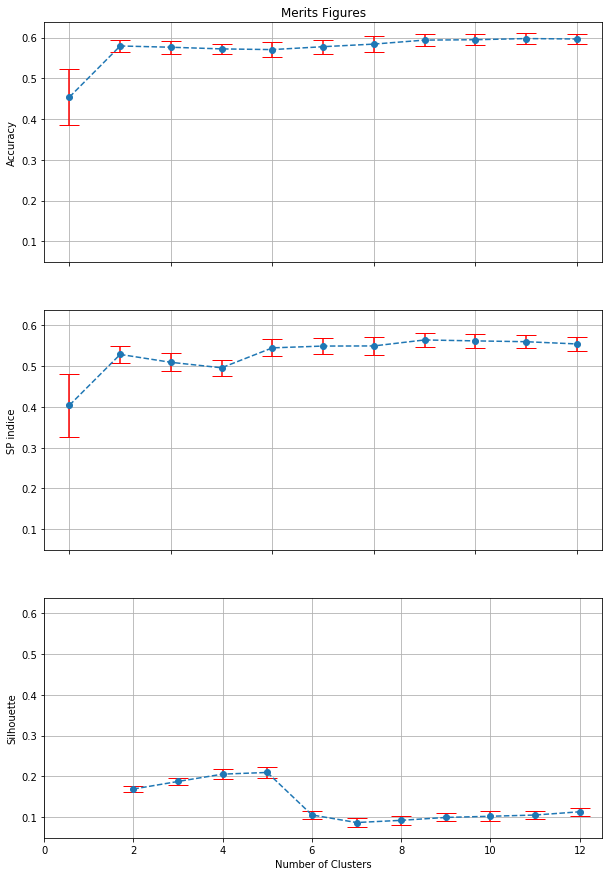

In [8]:
plt.figure(figsize=(10,10))

f, (ax1, ax2, ax3) = plt.subplots(3,figsize=(10,15), sharex=True, sharey=True)
ax1.errorbar(x, acc_mean, yerr=sigma_acc, fmt='--o',ecolor='r',capsize=10)
ax1.grid()
ax1.set_title('Merits Figures')
ax1.set_ylabel('Accuracy')
ax2.errorbar(x,SP_mean, yerr=sigma_SP, fmt='--o',ecolor='r',capsize=10)
ax2.set_ylabel('SP indice')
ax2.grid()
ax3.errorbar(x,sil_mean, yerr=sigma_sil,fmt='--o',ecolor='r',capsize=10)
ax3.set_ylabel('Silhouette')
ax3.grid()
ax3.set_xlabel('Number of Clusters')
ax3.set_xticks(np.arange(min(x)-2, max(x)+1, 2.0))
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
#f.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
f.savefig(path_tosave+'/'+'figuras_3em1_kmeans.pdf')

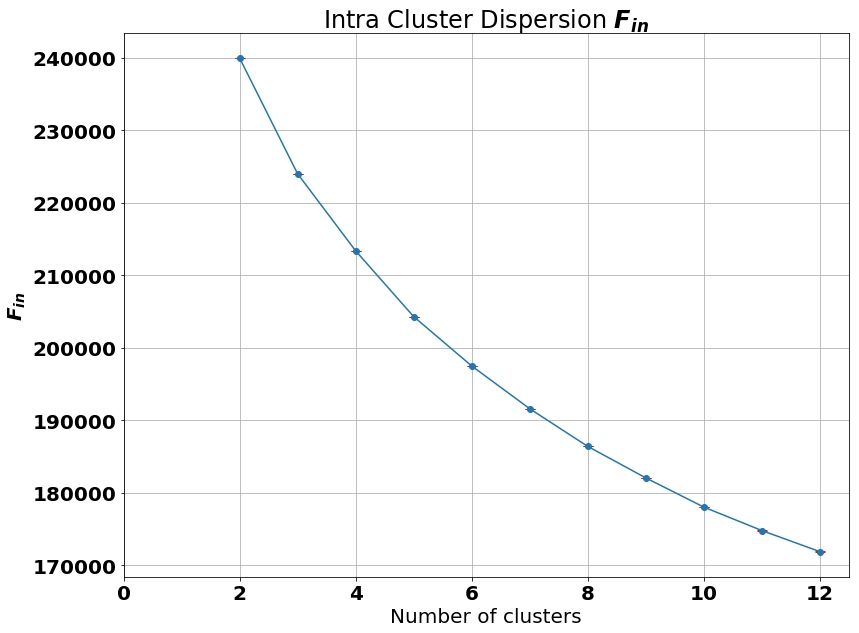

In [9]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,Fin_mean,yerr=sigma_Fin,ecolor='r',fmt='-o',capsize=5)
plt.title(r'Intra Cluster Dispersion $F_{in}$')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel(r'$F_{in}$')
plt.grid()
plt.savefig(path_tosave+'/'+'Fin_plot_kmeans.pdf')

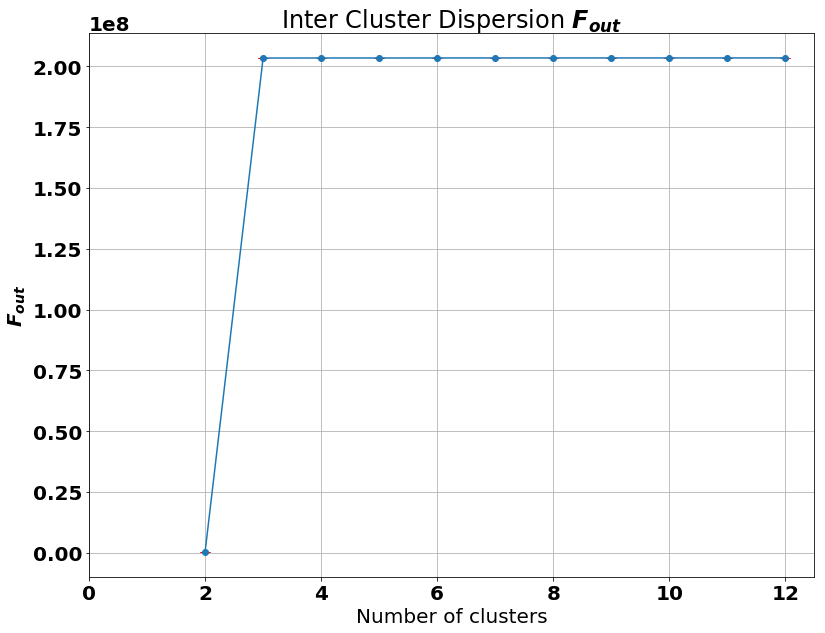

In [10]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,Fout_mean,yerr=sigma_Fout,ecolor='r',fmt='-o',capsize=5)
plt.title(r'Inter Cluster Dispersion $F_{out}$')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel(r'$F_{out}$')
plt.grid()
plt.savefig(path_tosave+'/'+'Fout_plot_kmeans.pdf')

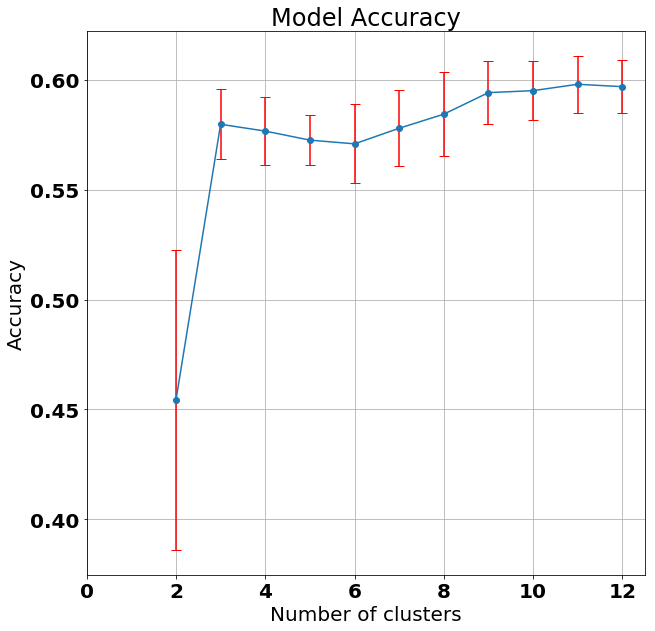

In [11]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(10,10))
plt.errorbar(x,acc_mean,yerr=sigma_acc,ecolor='r',fmt='-o',capsize=5)
plt.title('Model Accuracy')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel('Accuracy')
plt.grid()
plt.savefig(path_tosave+'/'+'Accuracy_plot_kmeans.pdf')

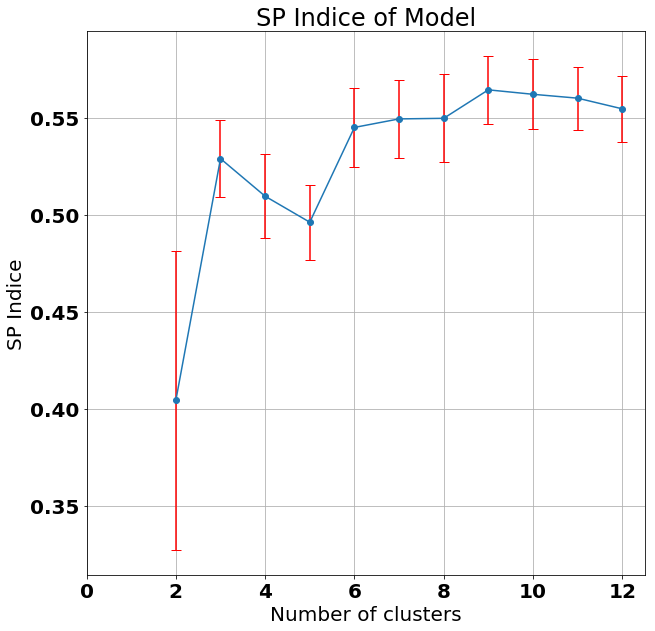

In [12]:
plt.figure(figsize=(10,10))
plt.errorbar(x,SP_mean,yerr=sigma_SP,ecolor='r',fmt='-o',capsize=5)
plt.title('SP Indice of Model')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel('SP Indice')
plt.grid()
plt.savefig(path_tosave+'/'+'SPindex_plot_kmeans.pdf')

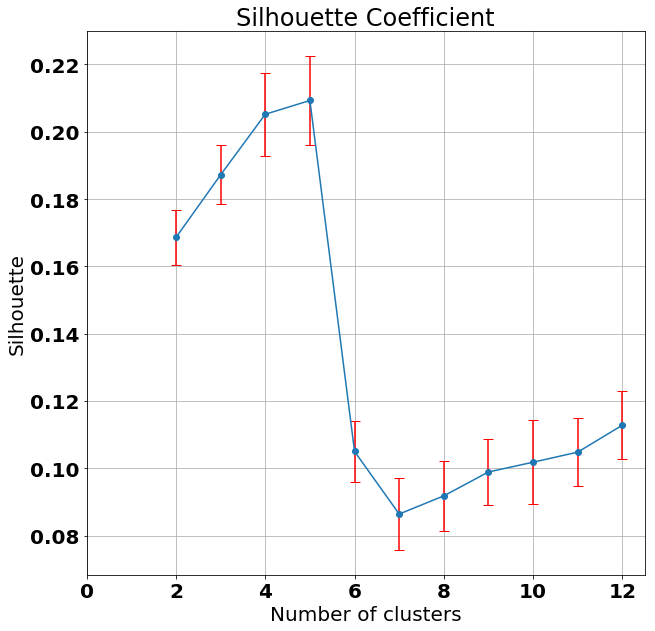

In [13]:
plt.figure(figsize=(10,10))
plt.errorbar(x,sil_mean,yerr=sigma_sil,ecolor='r',fmt='-o',capsize=5)
plt.title('Silhouette Coefficient')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel('Silhouette')
plt.grid()
plt.savefig(path_tosave+'/'+'Silhouette_plot_kmeans.pdf')

In [28]:
if sum(trgt[k_data==7]==1)/float(sum(k_data==7)) >0.5:
    print 'ok'

## A análise mostrou que para o método não-supervisionado 6 clusters é a melhor opção, para descrever o conjunto de dados

In [16]:
CVO = cross_validation.StratifiedKFold(trgt,n_folds)
CVO = list(CVO)
choose_fold = 0
classifiers = {}
for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    for i_init in range(n_inits):
        print ('Processing: Fold %i of %i Init %i of %i'%(
            ifold+1, n_folds, 
            i_init+1, n_inits)) 

        km = KMeans(n_clusters=5,random_state=0).fit(norm_data[train_id])
        classifiers[ifold]=km

km_output = classifiers[choose_fold].predict(norm_data)

Processing: Fold 1 of 10 Init 1 of 1
Processing: Fold 2 of 10 Init 1 of 1
Processing: Fold 3 of 10 Init 1 of 1
Processing: Fold 4 of 10 Init 1 of 1
Processing: Fold 5 of 10 Init 1 of 1
Processing: Fold 6 of 10 Init 1 of 1
Processing: Fold 7 of 10 Init 1 of 1
Processing: Fold 8 of 10 Init 1 of 1
Processing: Fold 9 of 10 Init 1 of 1
Processing: Fold 10 of 10 Init 1 of 1


In [18]:
class_final = np.zeros(trgt.shape)
for i in range(trgt.shape[0]):
    if sum(trgt[km_output==km_output[i]]==1)/float(sum(km_output==km_output[i])) >= 0.5:
        class_final[i]=1
    else:
        class_final[i]=0
np.unique(class_final)

array([ 0.,  1.])

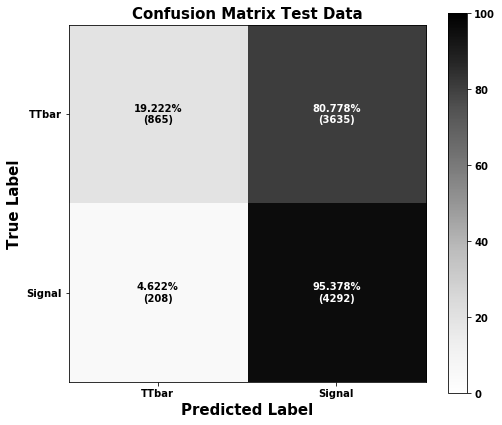

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

data_labels = ['TTbar','Signal']
plt.rcParams['font.weight'] = 'bold'

cm = confusion_matrix(trgt[train_id], class_final[train_id])
cm_data = cm
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix Test Data',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
plt.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_kmeansTRAIN.pdf')
#fig.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_5clustersttbar-4clustersignalTEST_BACKUP.pdf')

In [20]:
print 'Acc: ', round(np.mean(ClusterMerits.Acc(class_final,trgt)),3)
print 'Acc Score:', round(metrics.accuracy_score(trgt[test_id],class_final[test_id]),3)
print 'Indice SP: ',round(ClusterMerits.SP(class_final,trgt),3)
print 'Silhuet Coeficient: ',round(metrics.silhouette_score(norm_data,class_final),3)

Acc:  0.572
Acc Score: 0.566
Indice SP:  0.494
Silhuet Coeficient:  0.213


In [50]:
for i in range(trgt.shape[0]):
    print sum(trgt[k_data==k_data[i]]==1)/float(sum(k_data==k_data[i])) > 0.5

False
True
False
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
True
True
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
True
True
True
False
True
False
True
True
False
True
False
False
True
False
True
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
True
False
True
True
True
True
True
False
True
False
True
True
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
True
True
False
True
True
True
False
True
True
False
True
True
False
True
True


True
True
True
True
False
True
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
False
True
True
True
False
False
True
True
True
False
True
True
True
True
True
False
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
False
False
True
True
True
True
True
False
True
True
True
True
False
True
False
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
False
False
True
True
True
True
False
True
False
True
True
True
True
True
False
False
True
True
True
True
True
False
False
True
True
False
False
True
True
True
True
True
Tr

True
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
False
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
False
True
False
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
False
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
False
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True


True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
False
True
False
True
True
True
True
False
True
True
True
True
False
True
True
False
False
True
True
True
True
False
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
True
False
True
True
True
True
True
True
True
True
True
False
False
True
True
False
True
True
False
True
False
True
True
False
True
True
False
False
True
True
True
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
False
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
False
True
True
True
True
False
False
True
True
True
True
True
False
True
False
True
True
True
True
True
True
True
False
True
True
False
True
Tr

True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
False
False
False
True
False
True
False
False
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
True
True
False
True
True
False
True
True
True
False
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
True
True
True
True
False
False
True
True
True
True
True
False
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
False
True
True
True
True
True
False
True
True
False
True
True
False
True
True
True
True
True
False
True
False
True
True
True
True
True
False
True
False
True
False
True
True
True
False
True
True
False
True
True
True
False
True
True
False
True
False
True
True
True
True
True
True
True
True
True
True
False
Tru

True
True
True
False
True
False
True
False
False
True
True
False
True
True
True
True
True
True
True
True
True
False
False
False
True
False
True
False
False
True
True
True
True
True
True
False
True
False
False
True
True
True
True
True
False
True
True
True
False
True
False
True
True
True
False
False
True
True
True
False
True
True
True
False
True
True
True
True
True
False
True
False
True
True
False
True
True
True
False
False
False
True
False
False
True
True
True
True
False
False
False
False
True
True
True
True
True
False
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
False
True
False
False
True
False
True
True
True
True
False
False
True
True
False
True
True
False
True
True
True
False
True
False
True
False
False
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
False
False
False
True
True
True
True
True
False
False
True
False
True
True
False
True
True
True
True
False
True
False
True
True
False
True
False
False
True
True
True
True
Fals

True
True
True
True
True
True
False
False
True
True
False
True
True
True
True
True
True
False
True
True
True
False
True
True
True
True
False
True
True
True
True
True
True
True
False
False
True
False
False
False
True
False
True
True
True
True
False
False
True
True
False
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
False
False
False
True
False
True
True
True
True
True
True
False
True
True
True
False
False
True
True
True
True
True
False
True
False
True
True
True
True
True
True
True
False
True
False
False
True
True
True
True
True
True
True
False
True
False
False
True
True
True
True
True
False
True
True
True
True
True
True
False
False
True
False
True
True
False
True
True
True
True
False
True
True
True
True
True
True
True
True
True
False
True
True
True
True
False
True
True
True
True
True
False
False
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
False
